TODO: 
* 1. Check inner bias distribution
* 2. Plot weight distribution before/after quantization
* 3. Plot weight distribution before/after align limitation

### 1. Check inner bias / outer weight distribution

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.models import *
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels
from src.post_quant.utils import get_linear_layers, get_quant_layers


org_model = resmlp_24(pretrained=True).eval()

c:\Users\scott\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = resmlp_24(pretrained=True).eval()
m = get_linear_layers(model.blocks[0])
print([n for n,m in m])

['norm1', 'attn', 'gamma_1', 'norm2', 'mlp.fc1', 'mlp.fc2', 'gamma_2']


In [3]:
model = resmlp_24_v4(pretrained=True).eval()
m = get_linear_layers(model.blocks[0])
print([n for n,m in m])

['inner', 'outer', 'norm2', 'mlp.fc1', 'mlp.fc2', 'gamma_2']


In [4]:
def plot_layer(model, BLOCK, LAYER, save=False):
    name, layer = get_linear_layers(model.blocks[BLOCK])[LAYER]

    plt.rcParams["figure.figsize"] = [10, 6]
    plt.rcParams["figure.autolayout"] = True

    f, axes = plt.subplots(2, 2)
    weight = layer.weight
    bias = layer.bias

    # axes[0][0].set_title("bias", size=30)
    #ylabel("weight", size=30)
    # set_ylabel("weight", size=30)

    weight = weight.detach().numpy()
    x1 = weight.flatten()
    sns.heatmap(weight, center=0, cmap="PiYG", xticklabels=False, yticklabels=False, ax=axes[0][0])
    sns.histplot(x1, color="dodgerblue", kde=True,
        alpha=.4, edgecolor=(1, 1, 1), ax=axes[0][1])

    if bias is not None:
        bias = bias.detach().numpy()
        x2 = bias.flatten()
        if len(bias.shape) == 1:
            bias = bias.reshape(-1, 1)
            bias = bias.repeat(bias.shape[0], 1)
        
        sns.heatmap(bias, center=0, cmap="PiYG", xticklabels=False, yticklabels=False, ax=axes[1][0])
        sns.histplot(x2, color="dodgerblue", kde=True,
            alpha=.4, edgecolor=(1, 1, 1), ax=axes[1][1])


    axes[0][0].set_ylabel('Weight', size=16)
    axes[1][0].set_ylabel('Bias', size=16)

    axes[0][0].set_title("Heatmap", size=16)
    axes[0][1].set_title("Histplot", size=16)
    # save to folder
    if save:
        _ = plt.savefig(f"reports/v3_dist/layer_{BLOCK}_{LAYER}.png", dpi=300)
        plt.close()
    else:
        plt.show()

# plot_layer(model, 0, 3, save=False)

for i in range(24):
    for j in range(6):
        plot_layer(qmodel, i, j, save=True)

In [5]:
from torch.utils.tensorboard import SummaryWriter

In [6]:
def multipop(mylist, skip=[]):
    if len(skip) == 0:
        return mylist
    skip = sorted(skip)
    
    newlist = []
    skipcnt = -1
    for i, val in enumerate(mylist):
        skipcnt += 1
        if skipcnt >= len(skip):
            newlist.append(val)
            continue

        if i == skip[skipcnt]:
            continue
        else:
            newlist.append(val)
    return newlist


def draw_distribution_tensorboard(model, writer, skip=[]):
    cnt = 0
    for b_num in range(0,24):
        layers = get_linear_layers(model.blocks[b_num])
        layers = multipop(layers, skip=skip)
        for name, layer in layers:
            weight = layer.weight
            writer.add_histogram("weight", weight, cnt)

            bias = layer.bias
            if bias is not None:
                writer.add_histogram("bias", bias, cnt)

            cnt += 1

def compare_models(title, packs, skip=[]):
    for name, model in packs:
        print(f"runs/{title}/{name}")
        tb = SummaryWriter(f"runs/{title}/{name}")
        draw_distribution_tensorboard(model, tb, skip)

In [7]:
# org: ['norm1', 'attn', 'gamma_1', 'norm2', 'mlp.fc1', 'mlp.fc2', 'gamma_2']
#  v4: ['inner', 'outer', 'norm2', 'mlp.fc1', 'mlp.fc2', 'gamma_2']

# pack1 = ("org", resmlp_24(pretrained=True).eval())
# pack2 = ("v4", resmlp_24_v4(pretrained=True).eval())
# model3 = resmlp_24_v4(pretrained=False).eval()
# model3.load_state_dict(torch.load('v3/folder_sgd2/checkpoint.pth', map_location='cpu')["model"])
# pack3 = ("v4_l2", model3)

# compare_models("no_inner", [pack2, pack3], [0])
# compare_models("inner", [pack2, pack3], [1,2,3,4,5])
# compare_models("dist", [pack1, pack2, pack3])

### 2. Sketch activation distribution (N times each layer)

In [6]:
from src.post_quant.utils import HookHandler
from src.data_utils import getTrainData, calibrate

def detach_act_func(org_val, output):
    if org_val is None:
        arr = []
    else:
        arr = org_val

    arr.append(output.cpu().detach().numpy())
    return arr

def draw_activation_tensorboard(title, model):
    all_layers = []
    for i in range(24):
        all_layers.append(get_linear_layers(model.blocks[i], prefix=f"{i}_"))

    activations = {}
    hook_handler = HookHandler()
    hook_handler.create_apply_hook(detach_act_func, activations, all_layers)

    print("Loading a small piece of training data...")
    data_loader = getTrainData(dataset='imagenet', path="E:\datasets\imagenet", batch_size=32, data_percentage=0.0001)
    print("Calibrating...")
    calibrate(data_loader, model)
    hook_handler.remove_hook()

    data = []
    labels = []
    for layer in all_layers:
        for n, m in layer:
            data.append(activations[n])
            labels.append(n)
    
    for name, layer in zip(labels, data):
        tb = SummaryWriter(f"runs/{title}/{name}")
        for i, act in enumerate(layer[0]):
            tb.add_histogram("activation", np.absolute(act), i)

# draw_activation_tensorboard("act/org", resmlp_24(pretrained=True).eval())
# draw_activation_tensorboard("act/v4", resmlp_24_v4(pretrained=True).eval())


#### Draw Quant Model's Weight/Activation Distribution

In [8]:
model = resmlp_24(pretrained=True)
qmodel = q_resmlp_v4(model)

In [8]:
print("Calibrating...") #to obtain scale
data_loader = getTrainData(dataset='imagenet', path="E:\datasets\imagenet", batch_size=32, data_percentage=0.001)
calibrate(data_loader, qmodel, eval=False)

for name, layer in qmodel.named_modules():
    layer.requires_grad = False

Calibrating...
Calibrate: [ 0/41]	Time 16.529 (16.529)
Calibrate: [10/41]	Time  0.454 ( 1.937)
Calibrate: [20/41]	Time  0.384 ( 1.236)
Calibrate: [30/41]	Time  0.365 ( 0.959)
Calibrate: [40/41]	Time  0.264 ( 0.810)


In [10]:
get_linear_layers(qmodel.blocks[0])
# for name, module in qmodel.blocks[0].named_modules():
#     print(module)

[('inner', (384, 384, bias_bit=32)),
 ('outer', (196, 196, bias_bit=32)),
 ('norm2', (384, 384, bias_bit=32)),
 ('mlp.fc1', (384, 1536, bias_bit=32)),
 ('mlp.fc2', (1536, 384, bias_bit=32)),
 ('gamma_2', (384, 384, bias_bit=32))]

c:\Users\scott\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


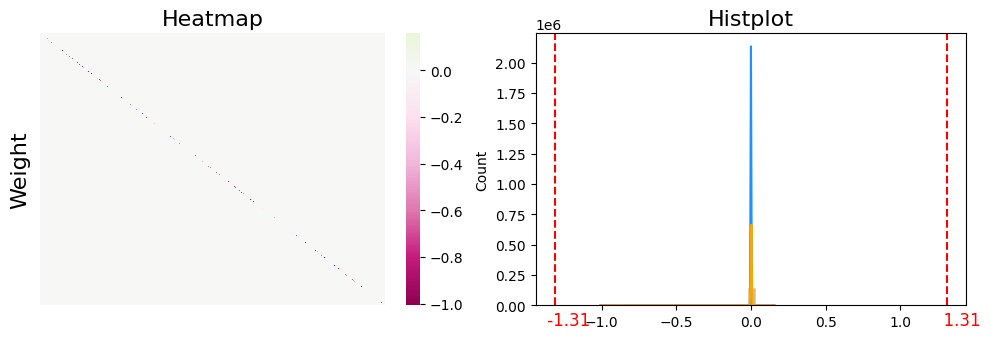

In [9]:
def plot_quantized_layer(qmodel, BLOCK, LAYER, save=False):
    name, layer = get_linear_layers(qmodel.blocks[BLOCK])[LAYER]

    plt.rcParams["figure.figsize"] = [10, 3.5]
    plt.rcParams["figure.autolayout"] = True

    f, axes = plt.subplots(1, 2)

    weight = layer.weight
    qweight = layer.w_int*layer.observer.scale

    weight = weight.detach().numpy()
    x1 = weight.flatten()

    qweight = qweight.detach().numpy()
    x2 = qweight.flatten()
    sns.heatmap(weight, center=0, cmap="PiYG", xticklabels=False, yticklabels=False, ax=axes[0])
    sns.histplot(x1, color="dodgerblue", kde=True,
        alpha=.4, edgecolor=(1, 1, 1), ax=axes[1])
    sns.histplot(x2, color="orange", kde=True,
        alpha=.4, edgecolor=(1, 1, 1), ax=axes[1])

    axes[0].set_ylabel('Weight', size=16)
    axes[0].set_title("Heatmap", size=16)
    axes[1].set_title("Histplot", size=16)

    scale = layer.observer.scale.detach().numpy()
    l, r = scale*layer.Qn, scale*layer.Qp
    plt.axvline(l, color="red", linestyle="--")
    plt.axvline(r, color="red", linestyle="--")
    
    trans = axes[1].get_xaxis_transform()
    plt.text(l, -.02, "{:10.2f}".format(l), transform=trans, ha='center', va='top', color="red", fontsize=12)
    plt.text(r, -.02, "{:10.2f}".format(r), transform=trans, ha='center', va='top', color="red", fontsize=12)

# save to folder
    if save:
        _ = plt.savefig(f"reports/v3_quant_compare/layer_{BLOCK}_{LAYER}.png", dpi=300)
        plt.close()
    else:
        plt.show()

# for i in range(24):
#     for j in range(6):
#         plot_quantized_layer(qmodel, i, j, save=True)
qmodel.cpu()
plot_quantized_layer(qmodel, 0, 0, save=False)

In [10]:
from src.post_quant.utils import HookHandler
from src.data_utils import getTrainData, calibrate

def detach_qact_func(org_val, output):
    if org_val is None:
        arr = []
    else:
        arr = org_val

    arr.append(output[0].cpu().detach().numpy())
    return arr

def draw_quantized_activation_tensorboard(title, qmodel):
    all_layers = []
    for i in range(24):
        all_layers.append(get_linear_layers(qmodel.blocks[i], prefix=f"{i}_"))

    activations = {}
    hook_handler = HookHandler()
    hook_handler.create_apply_hook(detach_qact_func, activations, all_layers)

    print("Loading a small piece of training data...")
    data_loader = getTrainData(dataset='imagenet', path="E:\datasets\imagenet", batch_size=32, data_percentage=0.0001)
    print("Calibrating...")
    calibrate(data_loader, qmodel, eval=False)
    hook_handler.remove_hook()

    all_layer_data = []
    for layer in all_layers:
        for n, m in layer:
            all_layer_data.append((n, activations[n]))

    for name, layer in all_layer_data:
        tb = SummaryWriter(f"runs/{title}/{name}")
        for i, act in enumerate(layer[0]):
            tb.add_histogram("activation", act, i)

draw_quantized_activation_tensorboard("act/q_v3", qmodel.eval())

Loading a small piece of training data...
Calibrating...
Calibrate: [0/4]	Time 10.465 (10.465)


NameError: name 'SummaryWriter' is not defined

In [13]:
# if res_act:  take prev 2 and add
# if act: take prev
# compare with output (fake quant) 

In [14]:
get_quant_layers(qmodel.blocks[23], prefix=f"{23}_")

[('23_inner', (384, 196, bias_bit=32)),
 ('23_act1', (to_bit=8, mult_bit=16)),
 ('23_outer', (196, 196, bias_bit=32)),
 ('23_add_1', (bias_bit=32, mult_bit=16)),
 ('23_norm2', (384, 384, bias_bit=32)),
 ('23_act2', (to_bit=8, mult_bit=16)),
 ('23_mlp.fc1', (384, 1536, bias_bit=32)),
 ('23_mlp.act', (to_bit=8, mult_bit=16)),
 ('23_mlp.fc2', (1536, 384, bias_bit=32)),
 ('23_act3', (to_bit=8, mult_bit=16)),
 ('23_gamma_2', (384, 384, bias_bit=32)),
 ('23_add_2', (bias_bit=32, mult_bit=16))]

In [17]:
def detach_qact_only_func(org_val, output):
    return output[0].cpu().detach()

def draw_quantized_activation_plot(title, qmodel):
    all_layers = []
    all_layers.append([get_quant_layers(qmodel.quant_patch, prefix=f"qp_")[1]])
    for i in range(24):
        all_layers.append(get_quant_layers(qmodel.blocks[i], prefix=f"{i}_"))

    activations = {}
    hook_handler = HookHandler()
    hook_handler.create_apply_hook(detach_qact_only_func, activations, all_layers)

    print("Loading a small piece of training data...")
    data_loader = getTrainData(dataset='imagenet', path="E:\datasets\imagenet", batch_size=16, data_percentage=0.0001)
    print("Calibrating...")
    calibrate(data_loader, qmodel, eval=False)
    hook_handler.remove_hook()
    del data_loader

    all_layer_data = []
    for layer in all_layers:
        for n, m in layer:
            all_layer_data.append((n, activations[n], m))

    prev_name, prev_act, prev_scale = None, None, None
    prev_add_name, prev_add_act, prev_add_scale = None, None, None
    for i in range(len(all_layer_data)):
        name, act, m = all_layer_data[i]
        act = act[0]
        scale = m.observer.scale

        if "act" in name:
            if i == 0:
                prev_add_name, prev_add_act, prev_add_scale = name, act, scale
                x1 = act.numpy().flatten()
                x2 = x1
            else:
                x1 = prev_act.numpy().flatten()
                x2 = act.numpy().flatten()
        elif "add" in name:
            x1 = (prev_add_act+prev_act).numpy().flatten()
            x2 = act.numpy().flatten()
        else:
            prev_name, prev_act, prev_scale = name, act, scale
            continue
        
        prev_name, prev_act, prev_scale = name, act, scale

        plt.rcParams["figure.figsize"] = [10, 3.5]
        plt.rcParams["figure.autolayout"] = True

        f, axes = plt.subplots(1)
        sns.histplot(x1, color="dodgerblue", kde=True,
            alpha=.4, edgecolor=(1, 1, 1), ax=axes)
        sns.histplot(x2, color="orange", kde=True,
            alpha=.4, edgecolor=(1, 1, 1), ax=axes)

        axes.set_ylabel('Activation', size=16)
        axes.set_title(f"{name}", size=16)

        scale = m.observer.scale.cpu().detach().numpy()
        l, r = scale*m.Qn, scale*m.Qp
        plt.axvline(l, color="red", linestyle="--")
        plt.axvline(r, color="red", linestyle="--")
        
        trans = axes.get_xaxis_transform()
        plt.text(l, -.02, "{:10.2f}".format(l), transform=trans, ha='center', va='top', color="red", fontsize=12)
        plt.text(r, -.02, "{:10.2f}".format(r), transform=trans, ha='center', va='top', color="red", fontsize=12)

        plt.savefig(f"{title}/{name}.png")
        plt.clf()
    
    # return all_layer_data

    # for name, layer in all_layer_data:
    #     tb = SummaryWriter(f"runs/{title}/{name}")
    #     for i, act in enumerate(layer[0]):
    #         tb.add_histogram("activation", act, i)
    
# draw_quantized_activation_tensorboard("act/q_v4_l2", qmodel.eval())
# draw_quantized_activation_plot("reports/quant/init_methods/lsq++", qmodel.eval())

Loading a small piece of training data...
Calibrating...
Calibrate: [0/8]	Time  8.180 ( 8.180)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000016084D55AF0>
Traceback (most recent call last):
  File "c:\Users\scott\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "c:\Users\scott\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 1468, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
C:\Users\scott\AppData\Local\Temp\ipykernel_21376\4087521966.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axes = plt.subplots(1)


<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

<Figure size 1000x350 with 0 Axes>

In [3]:
qmodel = q_resmlp_v3(org_model)

In [4]:
get_quant_layers(qmodel.blocks[21], prefix=f"{21}_")

[('21_crossPatch',
  QCrossPatch(
    training=True to_bit=8
    (observer): LSQObserver(mode=lab_weight, Qn=-127, Qp=127, calibrate_count=1, momentum=0.1)
    (observer2): LSQObserver(mode=lab_outer, Qn=-127, Qp=127, calibrate_count=1, momentum=0.1)
    (observer_act): LSQObserver(mode=lab_inner_act, Qn=-127, Qp=127, calibrate_count=20, momentum=0.1)
  )),
 ('21_add_1', (bias_bit=32, mult_bit=16)),
 ('21_linear1',
  QCrossLayer1(
    training=True to_bit=8
    (observer): LSQObserver(mode=lab_cross1, Qn=-127, Qp=127, calibrate_count=1, momentum=0.1)
  )),
 ('21_act3', (to_bit=8, mult_bit=16)),
 ('21_linear2', (1536, 384, bias_bit=32)),
 ('21_add_2', (bias_bit=32, mult_bit=16))]

### 3. Figure some method to fix alignment limitation

In [ ]:
get_quant_layers(qmodel.blocks[21], prefix=f"{21}_")